In [ ]:
#Загружаем требуемые нам библиотеки
%matplotlib inline
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
start_time = time.time()

In [ ]:
#Задаем размеры по высоте и ширине для наших картинок и приводим к ним их
imsize = 500 

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [ ]:
#Функция для загрузки изображений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


#Загружаем 2 стиля и контент
style_img = image_loader("Fire.jpg")
content_img = image_loader("Artem.jpg")

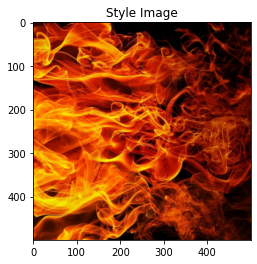

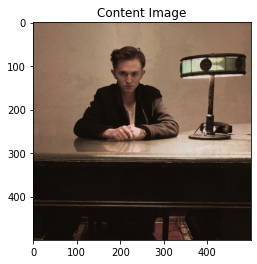

In [ ]:
#Смотрим на загруженные нами картинки
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_img, title='Style Image')



plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
#ЧАСТЬ С СЕГМЕНТАЦИЕЙ 
###########################################################################
from torchvision import models
import numpy as np

In [ ]:
model_1 = models.segmentation.fcn_resnet50(pretrained=True).to('cuda')
model_2 = models.segmentation.fcn_resnet101(pretrained=True).to('cuda')

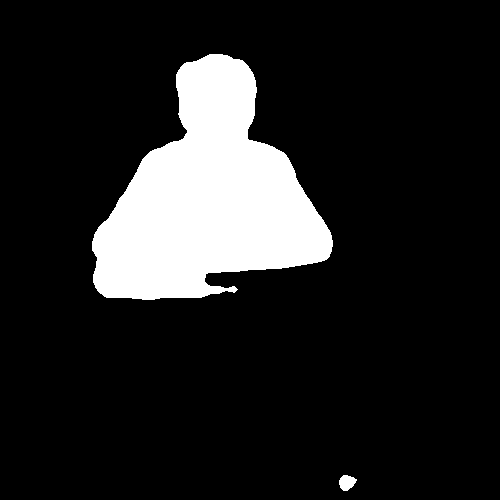

In [ ]:
y_pred = model_1(content_img)['out']
om1=torch.argmax(y_pred.squeeze(),dim=0).detach().to("cpu")
om1[om1>0]=1

y_pred = model_2(content_img)['out']
om2=torch.argmax(y_pred.squeeze(),dim=0).detach().to("cpu")
om2[om2>0]=1

om = om1 + om2
for ind1 in range(om.shape[0]):
  for ind2 in range(om.shape[1]):
    if (om[ind1][ind2]==2): om[ind1][ind2] = 1 

unloader(om.type(torch.FloatTensor))

In [ ]:
#Задаем класс новых словев в нашей нейросети, которе высчитывают лосс по контенту
class ContentLoss(nn.Module):

        def __init__(self, target):
            super(ContentLoss, self).__init__()

            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target )

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [ ]:
def gram_matrix(input):
        batch_size , h, w, map_num = input.size()  
        

        features = input.view(batch_size * h, w * map_num) 

        G = torch.mm(features, features.t()) 


        return G.div(batch_size * h * w * map_num)

In [ ]:
#Задаем класс новых словев в нашей нейросети, которе высчитывают лосс по стилю
class StyleLoss(nn.Module):
        def __init__(self, target_feature,mask):
            super(StyleLoss, self).__init__()            
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)
            self.mask=mask
        def forward(self, input):
          #Будем высчитывать Loss только по нашей маске
            _, _, h, w = input.size()
            mask_2d = unloader(self.mask.type(torch.FloatTensor))
            mask_2d = mask_2d.resize((h,w))
            mask_2d = transforms.ToTensor()(mask_2d)
        
            mask = torch.zeros_like(input)
            mask[:, :] = mask_2d.clone()
            mask = (1-mask).abs()
            G = gram_matrix(input*mask)
            self.loss = F.mse_loss(G, self.target)
            return input

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
def get_style_model_and_losses(cnn, mask, normalization_mean, normalization_std,
                                   style_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)


        normalization = Normalization(normalization_mean, normalization_std).to(device)

        content_losses = []
        style_losses_1 = []
        
        
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
        
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # добавляем по контенту потерю
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                #Добавление к нашей строющейся сети нового слоя потерь
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss_1 = StyleLoss(target_feature,mask)
                #Добавление к нашей строющейся сети нового слоя потерь
                model.add_module("style_loss_1{}".format(i), style_loss_1)
                style_losses_1.append(style_loss_1)

        
        
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses_1, content_losses

In [ ]:
def get_input_optimizer(input_img):
        
        #optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        optimizer = torch.optim.AdamW([input_img.requires_grad_()], lr=0.01)
        return optimizer

In [ ]:
losses_st = []
losses_cont = []
params=[]
def run_style_transfer(cnn, segment1, segment2,normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=2000,
                        style_1_weight=1000000, content_weight=100):
        #Задание маски для нашего алгоритма
        y_pred = segment1(content_img)['out']
        om1=torch.argmax(y_pred.squeeze(),dim=0).detach().to("cpu")
        om1[om1>0]=1

        y_pred = segment2(content_img)['out']
        om2=torch.argmax(y_pred.squeeze(),dim=0).detach().to("cpu")
        om2[om2>0]=1

        om = om1 + om2
        for ind1 in range(om.shape[0]):
          for ind2 in range(om.shape[1]):
            if (om[ind1][ind2]==2): om[ind1][ind2] = 1 
        mask = om
        model, style_losses_1, content_losses = get_style_model_and_losses(cnn,mask,
            normalization_mean, normalization_std, style_img, content_img)
        optimizer = get_input_optimizer(input_img)
        epoches = [0]



        while epoches[0] <= num_steps:

            def closure():
               
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score_1 = 0
                style_score_2 = 0
                content_score = 0

                for sl1 in style_losses_1:
                    style_score_1 += sl1.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ошибки
                style_score_1 *= style_1_weight
                content_score *= content_weight

               


                #сохранение ошибок для графика и получение конечной ошибки
                losses_st.append(style_score_1.item())
                losses_cont.append(content_score.item())
                #params.append(input_img)
                params.append(input_img.data.clamp_(0, 1))
                loss = style_score_1 + content_score
                #Высчитывание градиентов
                loss.backward()

                

                epoches[0] +=1
                if epoches[0] % 50 == 0:
                    print('number of epoches {}'.format(epoches[0]))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score_1.item(), content_score.item()))
      


                return style_score_1 + content_score

            optimizer.step(closure)

        
        input_img.data.clamp_(0, 1)

        return input_img

In [ ]:
input_img = content_img.clone()
#Попробуем сделать белый шум (начальная картинка)
#input_img = torch.rand(size=(1,3,imsize,imsize)).to(device)


plt.figure()
num_steps = 750
output = run_style_transfer(cnn, model_1,model_2,cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps = num_steps)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


number of epoches 50
Style Loss : 3487.989014 Content Loss: 1910.663940
number of epoches 100
Style Loss : 1931.425659 Content Loss: 1824.056763
number of epoches 150
Style Loss : 1003.365479 Content Loss: 1789.043213
number of epoches 200
Style Loss : 514.593018 Content Loss: 1754.630249
number of epoches 250
Style Loss : 356.079163 Content Loss: 1722.170410
number of epoches 300
Style Loss : 305.832611 Content Loss: 1698.281616
number of epoches 350
Style Loss : 283.751099 Content Loss: 1681.528809
number of epoches 400
Style Loss : 271.151703 Content Loss: 1668.770020
number of epoches 450
Style Loss : 262.632385 Content Loss: 1658.923584
number of epoches 500
Style Loss : 255.161377 Content Loss: 1652.901245
number of epoches 550
Style Loss : 261.709259 Content Loss: 1639.746094
number of epoches 600
Style Loss : 247.211868 Content Loss: 1640.696777
number of epoches 650
Style Loss : 242.507324 Content Loss: 1638.677979
number of epoches 700
Style Loss : 239.567474 Content Loss: 16

<Figure size 432x288 with 0 Axes>

In [ ]:
#Получим индекс минимального элемента в массиву losses_style
min_st=losses_st[0]
ind_min=0
for ind,el in enumerate(losses_st):
  if (el<min_st): 
    min_st=el
    ind_min=ind
output=params[ind_min].data.clamp_(0, 1)

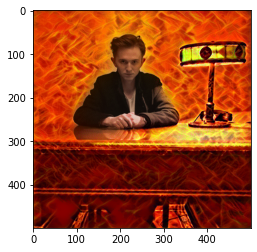

In [ ]:
#Фотография с наименьшей потерей по стилю
plt.figure()
imshow(output)
plt.ioff()
plt.show()

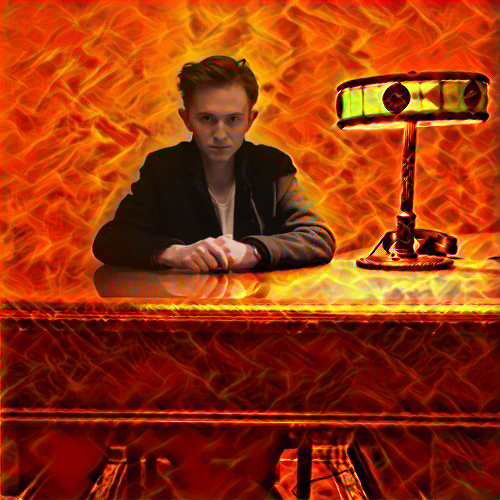

In [ ]:
to_pil = transforms.ToPILImage()
resh_out = to_pil(output.reshape(3,imsize,imsize))
resh_out

[Text(0, 0.5, 'Style Потери'), Text(0.5, 0, 'Количество Итераций')]

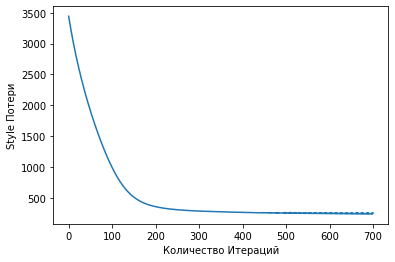

In [ ]:
fig = plt.figure()
ax_1= fig.add_subplot(1,1,1)
ax_1.plot([i for i in range(0, len(losses_st[50:]))], losses_st[50:])
ax_1.set(xlabel="Количество Итераций", ylabel="Style Потери")

In [ ]:
print(time.time()-start_time)

52.399890422821045
